# Predicting service operations from connected car telematics

* Nicholas Hirons
* Julian Kudszus
* Soham Kudtarkar
* Spencer Lee

In [1]:
import numpy as np
import pandas as pd
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

import importlib
import warnings
warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv('model_data_final.csv', index_col = 0)

# 1 Cleaning data

## 1.1 Cleaning operation code description strings

Operation code description strings had many spelling errors and merged words. I focussed on unmerging words using dynamic programming, but ignored any spelling mistakes.

In [3]:
from wordparser import infer_spaces, separate_merged_words

In [4]:
example_string = 'REPLACE 8 INJ, HIGHANDLOWPRESS FUEL PUMPS, FUELLINES AND RAILS, RELINEFUEL TANK, FLUSH FUELSYSTEM, LOF, NEW COOLANT|||PERFORM MULTI-POINTINSPECTION|BATTERY TEST PERFORMEDAND BATTERY OK ON THISVISIT| BATTERY TERMINALS GOOD ATTHIS TIME|TIRES INSPECTED AND OK ONTHIS VISIT.||SEE LINE A|DRAW TIME|DRAW TIME'

In [5]:
example_string

'REPLACE 8 INJ, HIGHANDLOWPRESS FUEL PUMPS, FUELLINES AND RAILS, RELINEFUEL TANK, FLUSH FUELSYSTEM, LOF, NEW COOLANT|||PERFORM MULTI-POINTINSPECTION|BATTERY TEST PERFORMEDAND BATTERY OK ON THISVISIT| BATTERY TERMINALS GOOD ATTHIS TIME|TIRES INSPECTED AND OK ONTHIS VISIT.||SEE LINE A|DRAW TIME|DRAW TIME'

In [6]:
separate_merged_words(example_string)

'replace inj high and low press fuel pumps fuel lines and rails reline fuel tank flush fuel system lof new coolant perform multi point inspection battery test performed and battery ok on this visit battery terminals good at this time tires inspected and ok on this visit see line a draw time draw time'

## 1.2 Extracting common service operations

I manually inferred the most common service operations from the most common word pairs in our operation code description 'corpus'. For example, looking below, 'multi point inspection' and 'battery test' are clearly very common services.

In [7]:
from wordparser import most_common_pairs_df

In [8]:
most_common_pairs_df(df['op_descriptions']).head(10)

,pair,count
0,"(this, visit)",8089
1,"(on, this)",8051
2,"(ok, on)",8003
3,"(multi, point)",6021
4,"(point, inspection)",6021
5,"(inspected, and)",5786
6,"(and, ok)",4680
7,"(perform, multi)",3891
8,"(battery, test)",3870
9,"(tires, inspected)",3640


# 2 Creating input features and output variables

## 2.1 Creating output variables from most common operations above

In [9]:
df[[col for col in df.columns if 'y_' in col]].head()

,y_bespoke,y_multi_point_inspection,y_battery_test,y_tire_inflation,y_hazardous_waste,y_change_oil,y_filter,y_safety_systems,y_nitro_fill,y_repair_or_refinish
0,0,1,1,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1,0,0,0
2,0,1,1,0,0,1,1,0,0,0
3,0,1,1,0,0,0,1,0,0,1
4,0,0,0,0,0,0,0,0,0,1


## 2.2 Creating input features

Various important input features were one hot encoded. My one-hot-encoding function allows a rank threshold input and/or a count threshold input. For a rank threshold of n, any category that is below the n-th rank in frequency will be mapped to 'other'. For a count threshold of k, any category with a frequency below k will be mapped to 'other'. The function will convert the most categories to other out of the rank and count thresholds.

In [10]:
from onehotencoding import one_hot_encode, add_one_hot_encoding

Below is an example of adding one hot encoding for error codes, where codes with frequency below 500 are mapped to 'other'.

In [11]:
add_one_hot_encoding(df[['error_code']], ['error_code'], count_threshold = 500).head()

,error_code,error_code_E302,error_code_E412,error_code_E420,error_code_E421,error_code_E502,error_code_E601,error_code_other
0,E601,0,0,0,0,0,1,0
1,E601,0,0,0,0,0,1,0
2,E412,0,1,0,0,0,0,0
3,E420,0,0,1,0,0,0,0
4,E421,0,0,0,1,0,0,0


# 3 Model training and evaluation

## 3.1 Create training and test sets

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV

In [13]:
df_y = df[[col for col in df.columns if 'y_' in col]]

In [14]:
df_y.head()

,y_bespoke,y_multi_point_inspection,y_battery_test,y_tire_inflation,y_hazardous_waste,y_change_oil,y_filter,y_safety_systems,y_nitro_fill,y_repair_or_refinish
0,0,1,1,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1,0,0,0
2,0,1,1,0,0,1,1,0,0,0
3,0,1,1,0,0,0,1,0,0,1
4,0,0,0,0,0,0,0,0,0,1


In [15]:
df_x = df.drop([col for col in df.columns if 'y_' in col], axis = 1)

Drop columns not to be used in model training.

In [16]:
df_x = df_x.drop(['make', 'op_descriptions', 'date', 'fuel',
                  'appointment_month', 'season', 'year', 'error_code'], axis = 1)

Check for null values.

In [17]:
df_x.isnull().sum()

make_ford             0
make_honda            0
make_hyundai          0
make_other            0
make_suzuki           0
engine_size         485
mileage             107
fuel_diesel           0
fuel_gas              0
season_fall           0
season_spring         0
season_summer         0
season_winter         0
age                   0
error_code_e302       0
error_code_e412       0
error_code_e420       0
error_code_e421       0
error_code_e502       0
error_code_e601       0
error_code_other      0
fuel_other            0
dtype: int64

For simplicity, fill NA values with median.

In [18]:
df_x = df_x.fillna(df_x.median())

I examined logistic regression, random forests, SVMs and k-Nearest Neighbors for each output variable. Due to output class imbalance, our key metric was F1 score. Our results suggested that the only algorithm that had predictive value for any output variable was k-NN.

Below I show an example of training k-NN using grid search on stratified 5-fold cross validation. All inputs were standard scaled.

In [19]:
scaler = StandardScaler()

In [20]:
df_x = scaler.fit_transform(df_x)

In [21]:
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.25, random_state=123)

## 3.2 Model training on k-NN

In [22]:
knn_model_dict = {}

for i, output_col in enumerate(df_y.columns):
    
    print('Fitting', output_col)
    y = y_train[output_col]
    
    parameter_grid = {
                 'n_neighbors' : [1,3,10],
                 'leaf_size': [10, 30, 100]
                 }
    knn = KNeighborsClassifier()
    cross_validation = StratifiedKFold(y, n_folds=5, random_state = 123)

    grid_search = GridSearchCV(knn,
                               scoring='f1',
                               param_grid=parameter_grid,
                               cv=cross_validation,
                               verbose = 1,
                               refit = True)

    grid_search.fit(x_train, y)
    knn_model_dict[output_col] = grid_search

Fitting y_bespoke
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   18.7s finished


Fitting y_multi_point_inspection
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   22.7s finished


Fitting y_battery_test
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   19.7s finished


Fitting y_tire_inflation
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   19.8s finished


Fitting y_hazardous_waste
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   18.5s finished


Fitting y_change_oil
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   20.1s finished


Fitting y_filter
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   18.6s finished


Fitting y_safety_systems
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   20.4s finished


Fitting y_nitro_fill
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   18.2s finished


Fitting y_repair_or_refinish
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   17.5s finished


Initially, we had evaluated our model on the existing training set. This yielded very weak F1-scores for every output besides 'repair or refinish', which, coincidentally, we considered to be the most important output variable (consumers and service providers would want to know ahead of time whether actual work needs to be done to the car).

In [23]:
refit_results_df = pd.read_csv('knn_results_refit.csv', index_col = 0)
refit_results_df

,accuracy,precision,recall,f-score
bespoke,0.567282,0.015625,0.039082,0.022325
multi point inspection,0.614525,0.116194,0.310210,0.169063
battery test,0.683505,0.101295,0.191011,0.132385
tire inflation,0.781943,0.102784,0.093796,0.098084
hazardous waste,0.818008,0.123746,0.072301,0.091274
change oil,0.800716,0.103495,0.075232,0.087129
filter,0.671216,0.091295,0.178798,0.120872
belts and hoses,0.812759,0.046083,0.024426,0.031928
air filter,0.824060,0.141964,0.077675,0.100410
safety systems,0.796023,0.048851,0.033219,0.039546


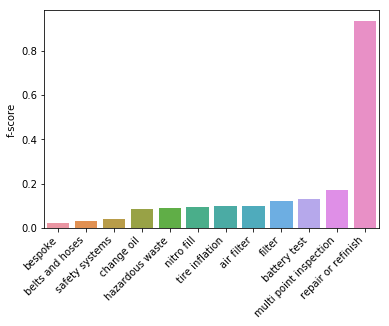

In [24]:
sns.barplot(x = refit_results_df['f-score'].sort_values().index,
            y = refit_results_df['f-score'].sort_values())
plt.xticks(rotation=45, ha = 'right')
plt.show()

However, this result is not particularly useful or interpretable, as it will overfit on the training and CV set. We need to consider performance on the test set.

In [25]:
knn_results = pd.DataFrame()

for output_col in df_y.columns:
    
    y_pred = knn_model_dict[output_col].predict(x_test)
    
    knn_results.loc[output_col, 'leaf size'] = knn_model_dict[output_col].best_params_['leaf_size']
    knn_results.loc[output_col, 'n neighbors'] = knn_model_dict[output_col].best_params_['n_neighbors']
    knn_results.loc[output_col, 'accuracy'] = round(sk.metrics.accuracy_score(y_test[output_col], y_pred),2)
    knn_results.loc[output_col, 'precision'] = round(sk.metrics.precision_score(y_test[output_col], y_pred),2)
    knn_results.loc[output_col, 'recall'] = round(sk.metrics.recall_score(y_test[output_col], y_pred),2)
    knn_results.loc[output_col, 'f-score'] = round(sk.metrics.f1_score(y_test[output_col], y_pred),2)

knn_results = knn_results.sort_values(by = 'f-score', ascending = False)
knn_results.index = [row[2:].replace('_', ' ') for row in knn_results.index]

In [26]:
knn_results

,leaf size,n neighbors,accuracy,precision,recall,f-score
tire inflation,30.0,3.0,0.92,0.66,0.67,0.67
multi point inspection,30.0,3.0,0.68,0.55,0.53,0.54
bespoke,100.0,1.0,0.65,0.45,0.46,0.46
battery test,10.0,1.0,0.73,0.45,0.42,0.44
hazardous waste,100.0,1.0,0.91,0.41,0.45,0.43
filter,10.0,1.0,0.69,0.40,0.38,0.39
nitro fill,100.0,3.0,0.95,0.41,0.34,0.37
safety systems,10.0,1.0,0.88,0.31,0.29,0.30
change oil,10.0,1.0,0.85,0.20,0.20,0.20
repair or refinish,100.0,1.0,0.80,0.21,0.18,0.19


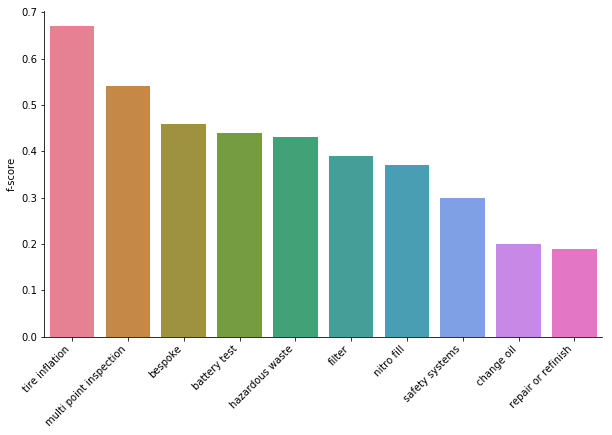

In [43]:
plt.figure(figsize = (10,6))
sns.barplot(x = knn_results['f-score'].index,
            y = knn_results['f-score'],
            palette = 'husl')
plt.xticks(rotation=45, ha = 'right')
sns.despine()
plt.show()

The results acros the board were fairly mixed, and suprisingly, repair/refinish did not have a high F-score on the test set. I'd also note that these results were also highly sensitive to the random states used in train/test splitting as well as stratified k-fold cross validation.

## 3.2 Example inference using our trained models

In [28]:
infer_df = pd.DataFrame()

for i, output_col in enumerate(df_y.columns):
    
    infer_df.loc['actual', output_col] = np.array(y_test)[100,i]
    infer_df.loc['predicted', output_col] = knn_model_dict[output_col].predict(x_test[100])[0]
    infer_df.loc['correct?', output_col] = (infer_df.loc['actual', output_col] == infer_df.loc['predicted', output_col])


infer_df.columns = [col[2:].replace('_', ' ') for col in infer_df.columns]

In [29]:
infer_df

,bespoke,multi point inspection,battery test,tire inflation,hazardous waste,change oil,filter,safety systems,nitro fill,repair or refinish
actual,0,0,0,1,1,0,0,0,0,0
predicted,0,1,0,1,1,0,1,0,0,0
correct?,True,False,True,True,True,True,False,True,True,True


# 4 Principal component analysis

We examine the distribution of data for tire inflation on the first two principal components, to explore why k-NN may have been more effective than other algorithms. Our intuition is classes don’t appear to be very separable, however, it makes sense that there are  neighborhoods / clusters of similar cars. An algorithm that is sensitive to the local structure of data, like k-NN, may therefore be the most effective for these applications.

In [30]:
from sklearn.decomposition import PCA

In [31]:
y_pca = df_y['y_tire_inflation']
x_pca = df_x

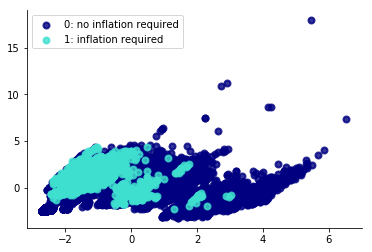

In [49]:
target_names = ['0: no inflation required', '1: inflation required']

pca = PCA(n_components=2)
X_r = pca.fit(x_pca).transform(x_pca)

plt.figure(figsize = (6,4))
colors = ['navy', 'turquoise']
lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y_pca == i, 0], X_r[y_pca == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='upper left', shadow=False, scatterpoints=1)
sns.despine()
plt.show()

# 5 Further areas of interest

We believe our results could be significantly improved by creating different models for different makes of car. Rather than using 'make' as a one hot encoded feature, we would use a subset of the data for training. This would also allow us to capture more information from the ‘tail-end’ of the make distribution.